# Creando Un Modelo

Instalamos la librería OpenSeesPy

In [1]:
pip install openseespy

     |████████████████████████████████| 133kB 7.5MB/s 
     |████████████████████████████████| 11.5MB 239kB/s 


In [2]:
pip install matplotlib==3.3.3

     |████████████████████████████████| 11.6MB 262kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Establecemos un Sistema de Unidades

In [3]:
# Unidades Base
m = 1
kg = 1
s = 1
# Otras Unidades
N = kg*m/s**2
cm = 0.01*m
Pa = N/m**2
ksi = 6894757.2932*Pa
kgf = 9.8066*N
MPa = 10**6*Pa
psi = 6894.76*Pa
# Constantes Físicas
g = 9.81*m/s**2

Importamos las librerías a utilizar

In [4]:
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
import matplotlib.pyplot as plt

AttributeError: ignored

Definimos las dimensiones y grados de libertad por nodo.

In [ ]:
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

Creamos nodos del modelo
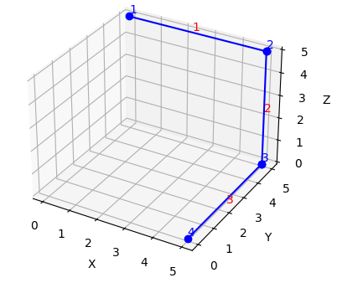

In [ ]:
ops.node(1, 0.0, 5.0, 5.0)
ops.node(2, 5.0, 5.0, 5.0)
ops.node(3, 5.0, 5.0, 0.0)
ops.node(4, 5.0, 0.0, 0.0)

Definimos la propiedad de los materiales

In [ ]:
E_mod = 1
G_mod = 1
Area = 4000000
Iy = 1000000
Iz = 300000
Jxx = 300000

Establecemos una transformación geométrica
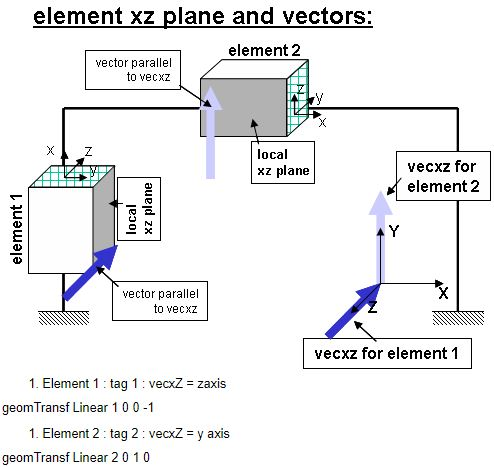

In [ ]:
ops.geomTransf('Linear', 1, *[0,1,0])
ops.geomTransf('Linear', 2, *[0,0,-1])

Definimos los elementos con sus propiedades respectivas

In [ ]:
ops.element('elasticBeamColumn', 1, 1, 2, Area, E_mod, G_mod, Jxx, Iy, Iz, 1)
ops.element('elasticBeamColumn', 2, 3, 2, Area, E_mod, G_mod, Jxx, Iy, Iz, 1)
ops.element('elasticBeamColumn', 3, 4, 3, Area, E_mod, G_mod, Jxx, Iy, Iz, 2)

Asignamos restricciones en los nodos

In [ ]:
ops.fix(1,*[1,1,1,1,1,1])
ops.fix(4,*[1,1,1,1,1,1])

Aplicamos una fuerza

In [ ]:
ops.timeSeries('Linear',1)
ops.pattern('Plain',1,1)
ops.load(2,0.0,-100.0,0.0,0.0,0.0,0.0)

Plotemos el modelo creado

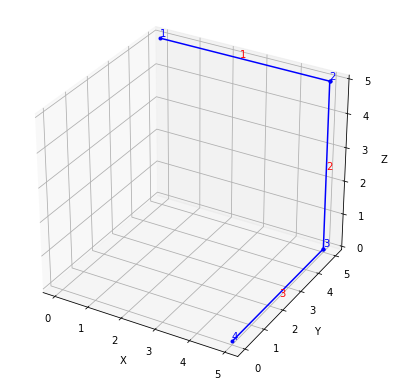

In [16]:
opsv.plot_model(fig_wi_he=(20., 15.))

Realizamos el análisis

In [13]:
ops.system('FullGeneral')
ops.numberer('Plain')
ops.constraints('Plain')
ops.integrator('LoadControl',1)
ops.algorithm('Linear')
ops.analysis('Static')
ops.analyze(1)

0

Se imprime algunos resultados

In [14]:
# Desplazamiento
disp = ops.nodeDisp(2)
print(disp)

# Fuerzas Internas
forceEle = ops.eleForce(1)
print(forceEle)

[4.610201428751115e-07, -0.002738350200303399, 0.0009053700570337016, 0.0005682593843134177, -0.00024655446124093283, -0.000791256660156555]
[-0.3688161143000892, 72.9800207915531, -8.322736433223444, -34.09556305880506, 35.600108757514576, 340.70138401019375, 0.3688161143000892, -72.9800207915531, 8.322736433223444, 34.09556305880506, 6.013573408602641, 24.198719947571732]


Se plotea la deformación obtenida

200

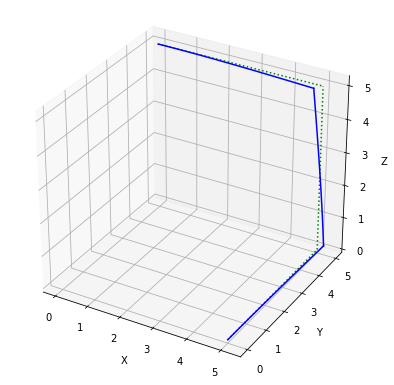

In [15]:
opsv.plot_defo(200,fig_wi_he=(20., 15.))
